# Staff line removal

Imports and definitions

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Image loading, binarization, inversion and display
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()
    
# Image morphological operations
def dilate(image):
    kernel = np.ones((1,100))
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((1,100))
    return cv2.erode(image, kernel, iterations=1)
def open_image(image):
    return dilate(erode(image))

# Horizontal projection
def horizontal_projection(image):
    hor_proj = []
    for i in range(len(image)):
        row_sum = 0
        for j in range(len(image[i])):
            row_sum += image[i][j] == 255
        hor_proj.append([255] * row_sum + [0] * (len(image[0]) - row_sum))

    return hor_proj

# Image crop
def crop_image(image, crop_start = None, crop_width = None):
    if crop_start is None:
        crop_start = len(image[0]) * 2//3
        
    if crop_width is None:
        crop_width = len(image[0]) // 10
    cutoff = image[:]
    
    for i in range(len(cutoff)):
        cutoff[i] = cutoff[i][crop_start : crop_start + crop_width] 

    cutoff = np.array(cutoff, dtype = np.uint8)
    return cutoff

# Find Y coordinates of white pixels
def find_y(image):
    y = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in y):
                y.append(i)
    return sorted(y)

# Intersect two lists
def intersect_lists(first, second):
    ret_val = []
    for val in first:
        if val in second:
            ret_val += [val]
    return ret_val

# Group points and get distances
def label_y(y_list):
    labels = [[]]
    line_distances = []
    prev_y = None
    for y in y_list:
        if prev_y is not None:
            if y - prev_y > 1:
                labels.append([])
                line_distances += [y - prev_y]
            labels[-1] += [y]
        prev_y = y
    return labels, line_distances

# Find lines
def find_lines(image):
    first = find_y(crop_image(horizontal_projection(image)))
    second = find_y(open_image(image))
    return label_y(intersect_lists(first, second))


Open image, binarize it and invert it.

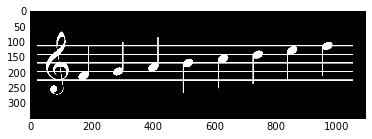

In [2]:
org_image = load_image("staff-with-notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
display_image(inv_img)

Find lines.

In [3]:
lines, distances = find_lines(inv_img)
print(lines)
print(distances)

[[114, 115, 116], [141, 142, 143, 144], [168, 169, 170, 171], [195, 196, 197, 198], [223, 224, 225, 226]]
[25, 24, 24, 25]


## Remove lines
We will try three different methods for staff line removal.

### Method A: Vertical check
This method checks for additional white non-line pixels above and below the part of the line. If there are such, that part of the line will not be removed.

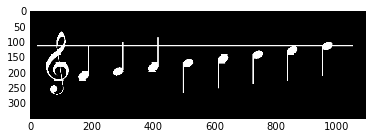

In [4]:
image = inv_img.copy()
for line in lines:
    top = line[0]
    bot = line[-1]
    for j in range(len(image[top])):
        remove = True
        is_line = False
        for row in image[top:bot+1]:
            if row[j] == 255:
                is_line = True
                break
        if not is_line:
            continue
        # check 2 pixels above and below
        diff = 2
        for row in image[top - diff : top]:
            if row[j] == 255:
                remove = False
                break
        if remove:
            for row in image[bot + 1: bot + diff + 1]:
                if row[j] == 255:
                    remove = False
                    break
        if remove:
            for row in image[top:bot+1]:
                row[j] = 0
display_image(image)

The method did not remove all lines. This is due to the imperfection of staff line recognition.

### Method B: Thickness-based removal
This method removes the part of the line if it's less thick than a certain threshold, usually the average staff line thickness or a bit smaller.

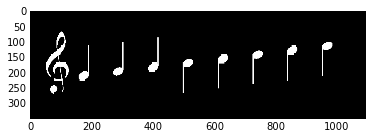

In [16]:
avg_thickness = lines[:]
for i, line in enumerate(avg_thickness):
    avg_thickness[i] = len(line)
avg_thickness = sum(avg_thickness) * 1./len(avg_thickness)


tolerance = 0.3
image = inv_img.copy()
for j in range(len(image[0])):
    white = False
    for i in range(len(image)):
        if image[i][j] == 255:
            if not white:
                start = i
            white = True
        else:
            if white:
                thickness = i - 1 - start
                if thickness < avg_thickness - tolerance:
                    for row in image[start : i]:
                        row[j] = 0
            white = False
display_image(image)


This method successfully removed all the staff lines. Some of the other elements, however, may have been disfigured a bit.

### Method C: Combination of methods A and B
